In [63]:
import os
import h5py
import cv2 # pip install opencv-python

import scipy.ndimage as sp
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from PIL import Image
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

In [3]:
os.chdir('/Users/hyunwoogu/Dropbox/2019/2019Autumn/Graduation/ResearchGrant/experiment/stimuli')

## Task structure

+ 


## Subroutines

+ Given Coord. of Center Point -> Matrix of the image part
+ 

In [434]:
def getAttention(center, img=img, w=600, h=600):
    halfw = int(w/2)
    halfh = int(h/2)
    
    return img[(center[0]-halfw):(center[0]+halfw),(center[1]-halfh):(center[1]+halfh),:]

In [435]:
# return normalized output
def getAttention2(center, img=img, w=600, h=600, reduce_factor=15):
    halfw = int(w/2)
    halfh = int(h/2)
    
    res   = img[(center[0]-halfw):(center[0]+halfw),(center[1]-halfh):(center[1]+halfh),:]
    res   = np.array(Image.fromarray(res).resize((int(w/reduce_factor),int(h/reduce_factor))))
    res   = np.mean(res, axis=2)[..., np.newaxis]    
    res   = res.astype(np.float32)
    res   = (res - np.mean(res))/np.std(res)

    return res

## Generate Stimuli

In [6]:
FileNames = os.listdir()

w,h=Image.open(FileNames[0]).size
N=len(FileNames)

arr=np.zeros((h,w,3),np.float)

for im in FileNames:
    imarr= np.array(Image.open(im),dtype=np.float)
    arr=arr+imarr/N

arr=np.array(np.round(arr),dtype=np.uint8)
out=Image.fromarray(arr,mode="RGB")
out.save("Average.png")
# out.show()

img = cv2.imread("Average.png", 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

In [185]:
for i in range(32):
    if i == 0:
        img_list = cv2.imread(str(i+1) + ".png", 1)
        img_list = cv2.resize(img_list, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        img_list = img_list[np.newaxis,:,:,:]
    else:
        im = cv2.imread(str(i+1) + ".png", 1)
        im = cv2.resize(im, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        im = im[np.newaxis,:,:,:]
        img_list = np.concatenate((img_list,im),axis=0)

## Points of Fixation

+ Central
+ Peripheral

In [8]:
# note that (xcoord, ycorrd)
centL = [600, 450]
centR = [1000, 450]

periL = [600, 750]
periR = [1000, 750]

In [579]:
fix_list = [centL, centR, periL, periR]

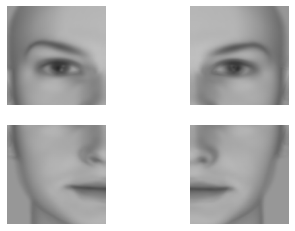

In [9]:
plt.subplot(221)
plt.imshow(getAttention(np.flip(centL)))
plt.axis('off')
plt.subplot(222)
plt.imshow(getAttention(np.flip(centR)))
plt.axis('off')
plt.subplot(223)
plt.imshow(getAttention(np.flip(periL)))
plt.axis('off')
plt.subplot(224)
plt.imshow(getAttention(np.flip(periR)))
plt.axis('off')
plt.show()

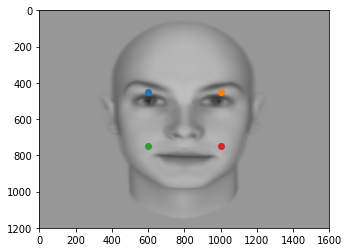

In [432]:
plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.scatter(centL[0],centL[1])
plt.scatter(centR[0],centR[1])
plt.scatter(periL[0],periL[1])
plt.scatter(periR[0],periR[1])


plt.show()

### Convolution Neural Network

+ Representational similarity betweeen identical faces

+ input normalization is needed!
+ attentional centers should be on the centeral (square)

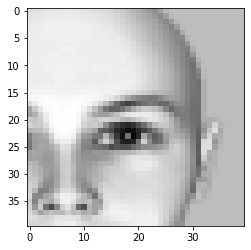

In [436]:
plt.imshow(getAttention2(np.flip(centR),img=img_list[24])[:,:,0], cmap="gray")
plt.show()

In [ ]:
np.flip(fix)

In [ ]:
ground_truth = np.zeros(bs,dtype=np.float32)

In [ ]:
def genPrepTrials():
    ran_x = np.random.uniform(low=600, high=1000, size=bs)
    ran_y = np.random.uniform(low=450, high=750, size=bs)

    stim_x = np.random.normal(scale=0.02, size=(bs,span,span,1)) # measurement noise
    ground_truth = np.zeros(bs,dtype=np.float32)

    for i in range(bs):
        ground_truth[i,:] = np.random.choice(range(32),1).astype(np.float32)
        stim_x += getAttention2([int(ran_y[i,0]),int(ran_x[i,0])],img=img_list[ground_truth[i,0]])
    return({'fix': fix, 'stim_x1':stim_x1, 'stim_x2':stim_x2, 'ground_truth':ground_truth, 'desired_output':desired_output})

In [578]:
def genPrepTrials(fix):
#     ran_x = np.random.uniform(low=600, high=1000, size=(bs,2))
#     ran_y = np.random.uniform(low=450, high=750, size=(bs,2))

    stim_x1 = np.random.normal(scale=0.02, size=(bs,span,span,1)) # measurement noise
    stim_x2 = np.random.normal(scale=0.02, size=(bs,span,span,1)) # measurement noise

    ground_truth   = np.zeros((bs,2),dtype=np.int64)
    desired_output = np.random.choice(2, bs, replace=True)

    for i in range(bs):
        # "identical" trials
        if desired_output[i]:
            ground_truth[i,:] = np.random.choice(range(32),1)
            stim_x1[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,0]])
            stim_x2[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,1]])
#             stim_x1[i,:,:,:] += getAttention2([int(ran_y[i,0]),int(ran_x[i,0])],img=img_list[ground_truth[i,0]])
#             stim_x2[i,:,:,:] += getAttention2([int(ran_y[i,1]),int(ran_x[i,1])],img=img_list[ground_truth[i,1]])
        # "different" trials
        else:
            ground_truth[i,0] = np.random.choice(range(32),1)
            ground_truth[i,1] = (ground_truth[i,0]+np.random.choice((-1.,1.),1)*diff_level)%32
            stim_x1[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,0]])
            stim_x2[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,1]])

#             stim_x1[i,:,:,:] += getAttention2([int(ran_y[i,0]),int(ran_x[i,0])],img=img_list[ground_truth[i,0]])
#             stim_x2[i,:,:,:] += getAttention2([int(ran_y[i,1]),int(ran_x[i,1])],img=img_list[ground_truth[i,1]])

#     return({'x':ran_x, 'y':ran_y, 'stim_x1':stim_x1, 'stim_x2':stim_x2, 'ground_truth':ground_truth, 'desired_output':desired_output})
    return({'fix': fix, 'stim_x1':stim_x1, 'stim_x2':stim_x2, 'ground_truth':ground_truth, 'desired_output':desired_output})

0


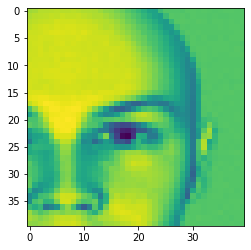

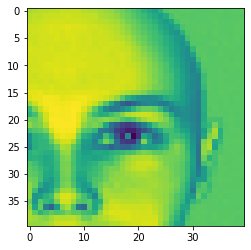

In [577]:
# testTrials = genPrepTrials(centR)
t = np.random.randint(bs)

print(testTrials['desired_output'][t])
plt.imshow(testTrials['stim_x1'][t,:,:,0])
plt.show()
plt.imshow(testTrials['stim_x2'][t,:,:,0])
plt.show()

#### Train!

In [593]:
span = 40 # attentional span size
ks = 10 # kernel size
bs = 512 # batch size
num_iter = 2000
diff_level = 8

In [601]:
tf.reset_default_graph()  # reset graphs in background

In [602]:
X1 = tf.placeholder(tf.float32, [None, span, span, 1])
X2 = tf.placeholder(tf.float32, [None, span, span, 1])
Y  = tf.placeholder(tf.float32, [None])

In [603]:
W = tf.Variable(tf.random_normal([ks, ks, 1, 32], stddev=0.01))

L1 = tf.nn.conv2d(X1, W, strides=[1, 3, 3, 1], padding='SAME')
L1 = tf.nn.relu(L1)

L2 = tf.nn.conv2d(X2, W, strides=[1, 3, 3, 1], padding='SAME')
L2 = tf.nn.relu(L2)

fc_dim = L1.shape[1].value * L1.shape[2].value * L1.shape[3].value

W_fc = tf.Variable(tf.random_normal([fc_dim, 512], stddev=0.01))
W_final = tf.Variable(tf.random_normal([512, 64], stddev=0.01))

L1_fc = tf.matmul(tf.reshape(L1, [-1, fc_dim]), W_fc)
L1_fc = tf.nn.relu(L1_fc) # representation of pic 1

L2_fc = tf.matmul(tf.reshape(L2, [-1, fc_dim]), W_fc)
L2_fc = tf.nn.relu(L2_fc) # representation of pic 2

L1_final = tf.nn.relu(tf.matmul(L1_fc, W_final))
L2_final = tf.nn.relu(tf.matmul(L2_fc, W_final))

In [604]:
evidence = tf.nn.tanh(tf.reduce_mean(tf.squared_difference(L1_final, L2_final),axis=1))
cost = tf.reduce_mean(tf.squared_difference(evidence, Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
accuracy = tf.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.dtypes.cast(evidence > 0.5, tf.float32), Y),tf.float32))

In [605]:
cost_hist = np.zeros(num_iter)
acc_hist = np.zeros(num_iter)

In [606]:
with tf.Session(graph=tf.get_default_graph()) as sess:
    sess.run(tf.global_variables_initializer())    
    for i in range(num_iter):
        trial_info = genPrepTrials(centR)
        _, cost_val, acc = sess.run([optimizer, cost, accuracy],
                 feed_dict = {X1: trial_info['stim_x1'], X2: trial_info['stim_x2'], 
                              Y:  trial_info['desired_output']})
        cost_hist[i] = cost_val
        acc_hist[i] = acc
        print("iter:",i,", cost:",cost_val, ", accuracy:",acc)
        weights = sess.run({'W':W, 'W_fc':W_fc, 'evidence': evidence}, 
                           feed_dict = {X1: trial_info['stim_x1'], X2: trial_info['stim_x2'], 
                                        Y:  trial_info['desired_output']})

iter: 0 , cost: 0.48242188 , accuracy: 0.5175781
iter: 1 , cost: 0.5234375 , accuracy: 0.4765625
iter: 2 , cost: 0.5175781 , accuracy: 0.48242188
iter: 3 , cost: 0.5234375 , accuracy: 0.4765625
iter: 4 , cost: 0.51171875 , accuracy: 0.48828125
iter: 5 , cost: 0.53125 , accuracy: 0.46875
iter: 6 , cost: 0.5292969 , accuracy: 0.47070312
iter: 7 , cost: 0.5214843 , accuracy: 0.47851562
iter: 8 , cost: 0.5527344 , accuracy: 0.44726562
iter: 9 , cost: 0.53515625 , accuracy: 0.46484375
iter: 10 , cost: 0.49999997 , accuracy: 0.5
iter: 11 , cost: 0.52539057 , accuracy: 0.47460938
iter: 12 , cost: 0.49804682 , accuracy: 0.5019531
iter: 13 , cost: 0.48437494 , accuracy: 0.515625
iter: 14 , cost: 0.50781244 , accuracy: 0.4921875
iter: 15 , cost: 0.5371093 , accuracy: 0.46289062
iter: 16 , cost: 0.4960937 , accuracy: 0.50390625
iter: 17 , cost: 0.54882807 , accuracy: 0.45117188
iter: 18 , cost: 0.50195307 , accuracy: 0.49804688
iter: 19 , cost: 0.49414062 , accuracy: 0.5058594
iter: 20 , cost: 0.

KeyboardInterrupt: 

### Recurrent Neural Network